In [1]:
from darwin.config import (
    CLASS_WEIGHT,
    CRITERION,
    FEATURE_NUM,
    MAX_DEPTH,
    PROCESSED_DATA_DIR,
    RANDOM_STATE,
    RANDOM_SEEDS,
    METRICS,
    RAW_DATA_DIR,
    SCORES_DIR,
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2025-04-08 11:34:45.049 | INFO     | darwin.config:<module>:11 - PROJ_ROOT path is: /Users/eduardoduarte/Projects/refactor-darwin/darwin


In [2]:
input_path = RAW_DATA_DIR / "data.csv"

In [3]:
df = pd.read_csv(input_path)

/var/folders/_y/56tk0_8d5jb15bryj56qxsjc0000gn/T/ipykernel_43722/1198701893.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, palette="viridis")


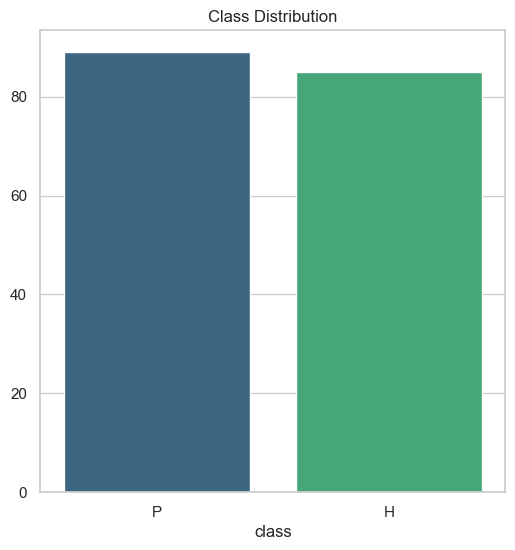

In [4]:
count = df["class"].value_counts()
sns.set_theme(style="whitegrid")

sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
sns.barplot(x=count.index, y=count.values, palette="viridis")
plt.title('Class Distribution')
plt.show()

In [5]:
df.isnull().values.any()

np.False_

In [20]:
def plot_class_balance(df, palette="viridis"):
    """
    Plots the number of columns of each type in the given DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        palette (str): The color palette to use for the plot.
    """
    # Count the number of columns for each data type
    y = df["class"].map({"P": "Case Group", "H": "Control Group"})
    count = y.value_counts()

    # Plot the data
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=count.index, y=count.values, palette=palette)

    # Annotate the bars with the counts
    for i, value in enumerate(count.values):
        ax.text(i, value/2, str(value), ha="center", fontsize=16, color="white")

    plt.title("Class Balance", fontsize=16)
    plt.xlabel("class", fontsize=12)
    plt.ylabel("count", fontsize=12)
    plt.xticks(ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_column_types(df, palette="viridis"):
    """
    Plots the number of columns of each type in the given DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        palette (str): The color palette to use for the plot.
    """
    # Count the number of columns for each data type
    types = df.dtypes.value_counts()

    # Plot the data
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=types.index.astype(str), y=types.values, palette=palette)

    # Annotate the bars with the counts
    for i, value in enumerate(types.values):
        ax.text(i, value/2, str(value), ha="center", fontsize=16, color="white")

    plt.title("Number of Feature Types", fontsize=16)
    plt.xlabel("data type", fontsize=12)
    plt.ylabel("count", fontsize=12)
    plt.xticks(ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

/var/folders/_y/56tk0_8d5jb15bryj56qxsjc0000gn/T/ipykernel_43722/3946010244.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=count.index, y=count.values, palette=palette)


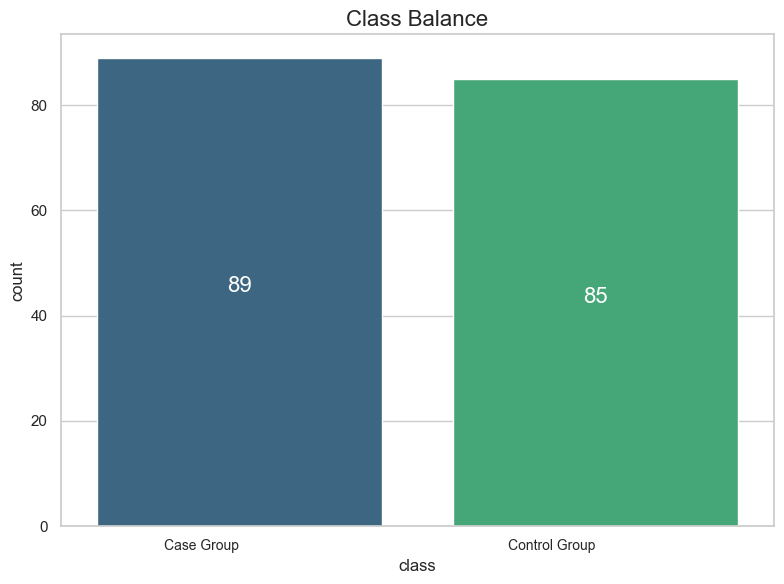

In [21]:
plot_class_balance(df, palette="viridis")

/var/folders/_y/56tk0_8d5jb15bryj56qxsjc0000gn/T/ipykernel_43722/3419191778.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=types.index.astype(str), y=types.values, palette=palette)


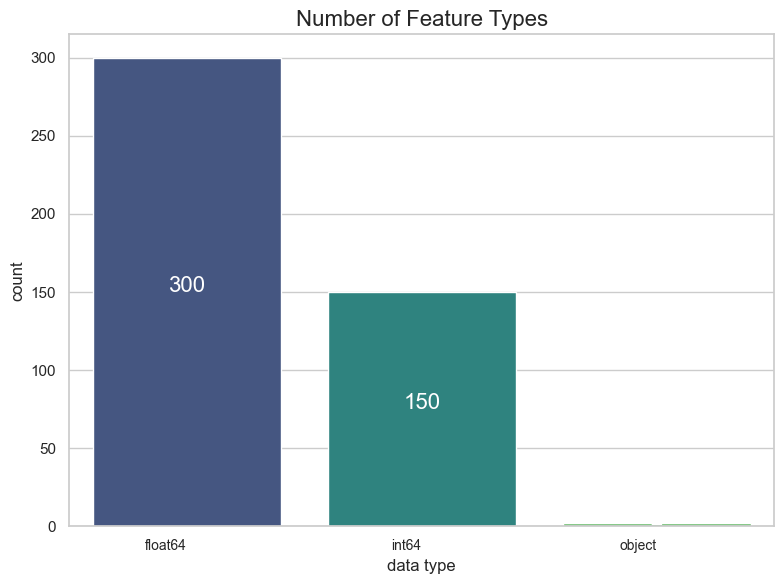

In [9]:
plot_column_types(df, palette="viridis")

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from pathlib import Path
target_path: Path = PROCESSED_DATA_DIR / "target.csv"

def evaluate_model(model, df: pd.DataFrame) -> pd.DataFrame:
    """
    Evaluate a model using cross-validation
    The model is evaluated using 5-fold cross-validation,
    metrics used to calculate the final score are defined in METRICS
    For each seed defined in RANDOM_SEEDS, the model is trained and evaluated
    The result is returned as a DataFrame with the metrics evaluated of the model in each seed
    The resulting DataFrame has |RANDOM_SEEDS|x|METRICS| dimensions
        model: estimator
            A sklearn estimator with fit() and predict() methods
        df: pd.DataFrame
            The input data
        return: pd.DataFrame
            A DataFrame with the metrics evaluated of the model in each seed
    """
    # Load the data
    X = df
    y = pd.read_csv(target_path)["class"]

    # Results should be e 2D matrix with |METRICS| columns and |RANDOM_SEEDS| rows
    results = {}

    # Loops through each seed
    # This is done to ensure that the results are robust to the randomness of the data
    for seed in RANDOM_SEEDS:
        scores = {}

        # Define the cross-validation strategy
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        # model.random_state = seed

        # Evaluate the model using cross-validation
        for metric in METRICS:
            scores[metric] = cross_val_score(model, X, y, scoring=metric, cv=kf, n_jobs=-1).mean()

        results[seed] = scores

    return pd.DataFrame(results).T

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

KNN = KNeighborsClassifier(
    n_neighbors=3,
    weights="uniform",
    metric="euclidean",
    algorithm="auto",
    leaf_size=10,
    p=1,
)

TREE = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    criterion="entropy",
    max_depth=5,
    class_weight="balanced",
)

MLP = MLPClassifier(
    hidden_layer_sizes=(100, 10),
    activation="relu",
    alpha=0.0001,
    solver="adam",
    random_state=RANDOM_STATE,
    learning_rate="constant",
    early_stopping=False,
    max_iter=1000,
)

models = {"knn": KNN, "tree": TREE, "mlp": MLP}

In [12]:
rfe_log_path: Path = PROCESSED_DATA_DIR / "rfe.csv"
rfe_tree_path: Path = PROCESSED_DATA_DIR / "rfe_tree.csv"
rfe_gdb_path: Path = PROCESSED_DATA_DIR / "rfe_gdb.csv"
preprocessed_data_path: Path = PROCESSED_DATA_DIR / "preprocessed_data.csv"

preprocessed_data = pd.read_csv(preprocessed_data_path).drop(["class"], axis="columns")

df_list = [
    pd.read_csv(rfe_log_path),
    pd.read_csv(rfe_tree_path),
    pd.read_csv(rfe_gdb_path),
]

name = ["log", "tree", "gdb"]

tree_score = evaluate_model(TREE, df_list[1])
knn_score = evaluate_model(KNN, df_list[1])
mlp_score = evaluate_model(MLP, df_list[1])
rfe_tree_score = pd.concat([tree_score, mlp_score, knn_score], keys=["tree", "mlp", "knn"])

In [13]:
tree_score = evaluate_model(TREE, df_list[2])
knn_score = evaluate_model(KNN, df_list[2])
mlp_score = evaluate_model(MLP, df_list[2])
rfe_gdb_score = pd.concat([tree_score, mlp_score, knn_score], keys=["tree", "mlp", "knn"])

In [14]:
rfe_tree_score.head()

accuracy  precision    recall        f1
tree 454  0.833445   0.855195  0.843791  0.840178
     167  0.850756   0.856257  0.853595  0.853979
     332  0.816471   0.814388  0.833333  0.820074
     322  0.798992   0.826204  0.786928  0.797966
     222  0.822353   0.895399  0.743137  0.808701

In [15]:
rfe_gdb_score.head()

accuracy  precision    recall        f1
tree 454  0.832941   0.851914  0.842484  0.839428
     167  0.868235   0.913611  0.820915  0.864030
     332  0.839832   0.869603  0.811111  0.835367
     322  0.833109   0.824906  0.864706  0.840466
     222  0.816471   0.817500  0.832026  0.823198

In [18]:

rfe_scores = pd.read_csv(f"{SCORES_DIR}/rfe_score.csv")
rfe_scores.head()

,Unnamed: 0,Unnamed: 1,accuracy,precision,recall,f1
0,tree,454,0.747731,0.767159,0.733333,0.742849
1,tree,167,0.764706,0.752601,0.809150,0.779500
2,tree,332,0.775966,0.811111,0.742484,0.772908
3,tree,322,0.798487,0.805742,0.820261,0.806130
4,tree,222,0.799328,0.834920,0.764706,0.796187
